# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Linear-Regression-problem" data-toc-modified-id="Linear-Regression-problem-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Linear Regression problem</a></div><div class="lev1 toc-item"><a href="#Gradient-Descent" data-toc-modified-id="Gradient-Descent-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Gradient Descent</a></div><div class="lev1 toc-item"><a href="#Gradient-Descent---Classification" data-toc-modified-id="Gradient-Descent---Classification-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gradient Descent - Classification</a></div><div class="lev1 toc-item"><a href="#Gradient-descent-with-numpy" data-toc-modified-id="Gradient-descent-with-numpy-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Gradient descent with numpy</a></div>

# Using Google Colab for Fast.ai

Welcome! Here is my one-stop-shop for getting all the Fast.ai lessons to work on Google Colab. I'll be updating this as I work through new lessons. Let me know if you have suggestions or improvements at @corythesaurus (DM me on Twitter).

My general workflow is to open each Fast.ai notebook and make a copy of it to save in my Drive, so I can add in my own cells as needed (and save them for later!). You can do that from within Colab: *File > Open Notebook... > click on "Github" tab > search for "fastai"*. All the notebooks should be there. Once you open a notebook, you can make a copy of it: *File > Save a copy in Drive...*. 

Finally, make sure you've enabled the GPU! *Edit > Notebook settings > set "Hardware Accelerator" to GPU.*

### The contribution of @denis-trofimov.
* bump PyTorch version
* make utilities quiet, less verbose
* unite install commands in one inside some sections

## Installing dependencies ##
We need to manually install fastai and pytorch. And maybe other things that fastai depends on (see [here](https://github.com/fastai/fastai/blob/master/requirements.txt)).

I will be referring to [this fastai forum thread](http://forums.fast.ai/t/colaboratory-and-fastai/10122/6) and [this blogpost](https://towardsdatascience.com/fast-ai-lesson-1-on-google-colab-free-gpu-d2af89f53604) if I get stuck. This is also a handy resource for using pytorch in colab:   https://jovianlin.io/pytorch-with-gpu-in-google-colab/ (and his [example notebook](https://colab.research.google.com/drive/1jxUPzMsAkBboHMQtGyfv5M5c7hU8Ss2c#scrollTo=ed-8FUn2GqQ4)!). And this [post](https://medium.com/@chsafouane/getting-started-with-pytorch-on-google-colab-811c59a656b6).

In [0]:
# Install PyTorch fastai
!pip3 install -q http://download.pytorch.org/whl/cu80/torch-0.3.1-cp36-cp36m-linux_x86_64.whl fastai torchvision

### Special additions for particular lessons

If anyone gets KeyError: 'ffmpeg' running the SGD notebook (in the animation cell) you probably need to install ffmpeg.
Then restarted kernel and it worked. 

In [2]:
!apt install -qq -y ffmpeg

ffmpeg is already the newest version (7:3.3.4-2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


## GPU setup ##
Google is very generous and gives access to a GPU for CoLab users. Make sure it's enabled: Edit > Notebook settings > set "Hardware accelerator" to GPU.

The following is just to assuage your fears that you're being rate-limited or otherwise; you don't need to add these cells to your notebooks to get them to run. Just make sure you've enabled the GPU in the notebook settings. This is easy to forget :)

In [0]:
%matplotlib inline
from fastai.learner import *

In this part of the lecture we explain Stochastic Gradient Descent (SGD) which is an **optimization** method commonly used in neural networks. We will illustrate the concepts with concrete examples.

#  Linear Regression problem

The goal of linear regression is to fit a line to a set of points.

In [0]:
# Here we generate some fake data
def lin(a,b,x): return a*x+b

def gen_fake_data(n, a, b):
    x = s = np.random.uniform(0,1,n) 
    y = lin(a,b,x) + 0.1 * np.random.normal(0,3,n)
    return x, y

x, y = gen_fake_data(50, 3., 8.)

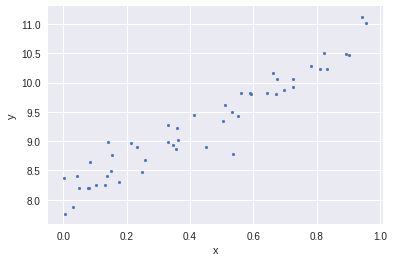

In [5]:
plt.scatter(x,y, s=8); plt.xlabel("x"); plt.ylabel("y"); 

You want to find **parameters** (weights) $a$ and $b$ such that you minimize the *error* between the points and the line $a\cdot x + b$. Note that here $a$ and $b$ are unknown. For a regression problem the most common *error function* or *loss function* is the **mean squared error**. 

In [0]:
def mse(y_hat, y): return ((y_hat - y) ** 2).mean()

Suppose we believe $a = 10$ and $b = 5$ then we can compute `y_hat` which is our *prediction* and then compute our error.

In [7]:
y_hat = lin(10,5,x)
mse(y_hat, y)

4.29358931545332

In [0]:
def mse_loss(a, b, x, y): return mse(lin(a,b,x), y)

In [9]:
mse_loss(10, 5, x, y)

4.29358931545332

So far we have specified the *model* (linear regression) and the *evaluation criteria* (or *loss function*). Now we need to handle *optimization*; that is, how do we find the best values for $a$ and $b$? How do we find the best *fitting* linear regression.

# Gradient Descent

For a fixed dataset $x$ and $y$ `mse_loss(a,b)` is a function of $a$ and $b$. We would like to find the values of $a$ and $b$ that minimize that function.

**Gradient descent** is an algorithm that minimizes functions. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. This iterative minimization is achieved by taking steps in the negative direction of the function gradient.

Here is gradient descent implemented in [PyTorch](http://pytorch.org/).

In [10]:
# generate some more data
x, y = gen_fake_data(10000, 3., 8.)
x.shape, y.shape

((10000,), (10000,))

In [0]:
x,y = V(x),V(y)

In [12]:
# Create random weights a and b, and wrap them in Variables.
a = V(np.random.randn(1), requires_grad=True)
b = V(np.random.randn(1), requires_grad=True)
a,b

(Variable containing:
 -1.0550
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
 -2.4389
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [13]:
learning_rate = 1e-3
for t in range(10000):
    # Forward pass: compute predicted y using operations on Variables
    loss = mse_loss(a,b,x,y)
    if t % 1000 == 0: print(loss.data[0])
    
    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    # After this call a.grad and b.grad will be Variables holding the gradient
    # of the loss with respect to a and b respectively
    loss.backward()
    
    # Update a and b using gradient descent; a.data and b.data are Tensors,
    # a.grad and b.grad are Variables and a.grad.data and b.grad.data are Tensors
    a.data -= learning_rate * a.grad.data
    b.data -= learning_rate * b.grad.data
    
    # Zero the gradients
    a.grad.data.zero_()
    b.grad.data.zero_()    

156.49072265625
1.163103699684143
0.16317737102508545
0.14135733246803284
0.12927672266960144
0.12000664323568344
0.11287008225917816
0.10737579315900803
0.10314606875181198
0.09988949447870255


Nearly all of deep learning is powered by one very important algorithm: **stochastic gradient descent (SGD)**. SGD can be seeing as an approximation of **gradient descent** (GD). In GD you have to run through *all* the samples in your training set to do a single itaration. In SGD you use *only one* or *a subset*  of training samples to do the update for a parameter in a particular iteration. The subset use in every iteration is called a **batch** or **minibatch**.

# Gradient Descent - Classification

For a fixed dataset $x$ and $y$ `mse_loss(a,b)` is a function of $a$ and $b$. We would like to find the values of $a$ and $b$ that minimize that function.

**Gradient descent** is an algorithm that minimizes functions. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. This iterative minimization is achieved by taking steps in the negative direction of the function gradient.

Here is gradient descent implemented in [PyTorch](http://pytorch.org/).

In [0]:
def gen_fake_data2(n, a, b):
    x = s = np.random.uniform(0,1,n) 
    y = lin(a,b,x) + 0.1 * np.random.normal(0,3,n)
    return x, np.where(y>10, 1, 0).astype(np.float32)

In [0]:
x,y = gen_fake_data2(10000, 3., 8.)
x,y = V(x),V(y)

In [0]:
def nll(y_hat, y):
    y_hat = torch.clamp(y_hat, 1e-5, 1-1e-5)
    return (y*y_hat.log() + (1-y)*(1-y_hat).log()).mean()

In [0]:
a = V(np.random.randn(1), requires_grad=True)
b = V(np.random.randn(1), requires_grad=True)

In [18]:
learning_rate = 1e-2
for t in range(3000):
    p = (-lin(a,b,x)).exp()
    y_hat = 1/(1+p)
    loss = nll(y_hat,y)
    if t % 1000 == 0:
        print(loss.data[0], np.mean(to_np(y)==(to_np(y_hat)>0.5)))
#         print(y_hat)
    
    loss.backward()
    a.data -= learning_rate * a.grad.data
    b.data -= learning_rate * b.grad.data
    a.grad.data.zero_()
    b.grad.data.zero_()    

-0.7053936719894409 0.6646
-1.088179588317871 0.6646
-2.68908429145813 0.6646


Nearly all of deep learning is powered by one very important algorithm: **stochastic gradient descent (SGD)**. SGD can be seeing as an approximation of **gradient descent** (GD). In GD you have to run through *all* the samples in your training set to do a single itaration. In SGD you use *only one* or *a subset*  of training samples to do the update for a parameter in a particular iteration. The subset use in every iteration is called a **batch** or **minibatch**.

# Gradient descent with numpy

In [0]:
from matplotlib import rcParams, animation, rc
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
rc('animation', html='html5')
rcParams['figure.figsize'] = 3, 3

In [0]:
x, y = gen_fake_data(300, 3., 8.)

In [26]:
a_guess,b_guess = -1., 1.
mse_loss(a_guess, b_guess, x, y)

81.64057739556297

In [0]:
lr=0.01
def upd():
    global a_guess, b_guess
    y_pred = lin(a_guess, b_guess, x)
    dydb = 2 * (y_pred - y)
    dyda = x*dydb
    a_guess -= lr*dyda.mean()
    b_guess -= lr*dydb.mean()

In [28]:
fig = plt.figure(dpi=100, figsize=(5, 4))
plt.scatter(x,y)
line, = plt.plot(x,lin(a_guess,b_guess,x))
plt.close()

def animate(i):
    line.set_ydata(lin(a_guess,b_guess,x))
    for i in range(30): upd()
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(0, 20), interval=100)
ani